## 2. notebook for looking at 2ds data
similar to extracting individual crystals, but firstly we want to seperate out (with certainty) whole crystals vs noise (i.e. lots of small particles)

this notebook is just for looking at 1 crystal

how to extract + save useful crystal + relevant stats

In [27]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from glob import glob
import seaborn as sns
import xesmf as xe
import pandas as pd
#import def_homebrew as hb ## homemade functions xox
from scipy.special import gamma
import netCDF4 as nc
from datetime import datetime, timedelta

import h5py ####
from PIL import Image
#from IPython.display import display #
#import cv2 # not working
import os

from scipy.ndimage import convolve, label
from skimage.measure import regionprops, find_contours
from scipy.spatial import ConvexHull, distance_matrix
from skimage.morphology import remove_small_holes ## remove holes <3
from scipy.ndimage import binary_fill_holes
from skimage import measure
from cv2 import cvtColor, COLOR_BGR2GRAY, threshold, THRESH_BINARY, THRESH_OTSU

In [28]:
## files location
ds_loc = '/home/users/esree/data/2ds/'
hvps_loc = '/home/users/esree/data/hvps/'

#file of interest
file_name = 'Export_base220730153000.h5' # example file
f2ds = h5py.File(ds_loc+ file_name,'r') # open file

# break file into two - data + time
ds_image = f2ds['ImageData'] 
ds_time = f2ds['ImageTimes']
## ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
##### make xarray of useful time data #####
sec_since = ds_time[:,0]
pixel_slice = ds_time[:,1]
pix_sum = pixel_slice.cumsum(dtype = 'int')

## make useful datetime format (not seconds since midnight)
# using the file name for reference
date_str = file_name[11:17]
starting_date = datetime.strptime(date_str, '%y%m%d')
time_deltas = [timedelta(seconds=float(sec)) for sec in sec_since]
utc_time = [starting_date + delta for delta in time_deltas]

time_xr =xr.Dataset({
    'utc_time':utc_time,
    'pixel_slice': pixel_slice,
    'pix_sum': pix_sum})
## ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

### first step in quick cleaning (just reduce sample size)
* (here images are defined as pre-determined by Jonny)
* get rid of images where less than 4 pixels along x axis i.e. indexes are very close together for images

In [43]:
diff = np.diff(time_xr['pix_sum'][:].values) # this is finding the difference between the elements of pix_sum
selected_values = time_xr['pix_sum'][:-1][diff > 4] # this is selecting the adjacent files in which have pixels > 4 length
# i.e. selected values contains the index of where images are > 4 in x axis

In [102]:
len(selected_values)

22822

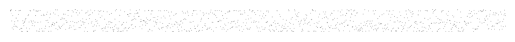

In [109]:
i = len(selected_values)-2 # random crystal
## 32, 2344, 3452 is good example, 700 - we would want rid of
one_crystal = f2ds['ImageData'][:,int(selected_values[i]):int(selected_values[i+1])] # extract 1 crystal

plt.imshow(one_crystal, cmap='gray')
plt.axis('off') # Turn off axis labels
plt.show()

In [90]:
def stats_description(bw_crystal):
    '''take binary image, fill in small holes and returns object containing stats about crystal'''
    
    filled_particle = remove_small_holes(bw_crystal.image, area_threshold=4) # fill in voids within binary image - better estimation of stats # may need to be altered
    
    # can see the filled in particle if needs be
    #plt.imshow(filled_particle, cmap='gray')
    
    contours = measure.find_contours(filled_particle, 0.5)
    if contours:
        contour = max(contours, key=lambda x: x.shape[0])  # Sort contours by area (largest first) and select the largest contour
        
        labeled_image = measure.label(filled_particle)  # Label the image based on the threshold
        region = measure.regionprops(labeled_image)[0]  # Assumes largest labeled region corresponds to largest contour
        
        return region
    else:
        return None

# function to add padding to extracted crystal - better sample to match Jaffeux
def add_padding(one_crystal, desired_png_size):
    # Calculate padding
    pad_height = (desired_png_size - one_crystal.shape[0]) // 2
    pad_width = (desired_png_size - one_crystal.shape[1]) // 2
    
    # Pad the image
    padded_image = np.pad(one_crystal, ((pad_height, pad_height), (pad_width, pad_width)), mode='constant', constant_values=255)
    
    # In case the dimensions are odd, add an extra row/column to match the desired size
    if padded_image.shape[0] < desired_size:
        padded_image = np.pad(padded_image, ((0, 1), (0, 0)), mode='constant', constant_values=255)
    if padded_image.shape[1] < desired_size:
        padded_image = np.pad(padded_image, ((0, 0), (0, 1)), mode='constant', constant_values=255)

    return padded_image


In [80]:
## taking our cleaned data, where the files are indexed >4 in length

# ! the sectioned up data may contain >1 image of ice #
 
# 1. want to find all objects in the sections
# 2. identify objects in which the max dimension is > than specific threshold
# 3. extract start + end index of said particle
# 4. use this index to slice + get corresponding UTC time associated with particle
# 5. get useful stats about particle + add to df

length_threshold = 300 # mu - need this minimum length of max dimension to extract the particle
pixel_resolution = 10 # mu
desired_image_size = 120
# ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~  #
minimum_area = 10 # very quick metric to stop the processing of particles with area < 10 pixels

###  set up dataframe, used to extract from raw h5 file + has stats about the particle
columns = [
    "name",
    "particle_label",
    "start_index",
    "end_index",
    "start_time",
    "end_time",
    "major_axis_length",
    "minor_axis_length",
    "orientation",
    "centroid",
    "area",
    "perimeter",
    "y0",
    "y1"
]
particle_df = pd.DataFrame(columns=columns)
# ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~  #

# convert whole image true / false
binary_image = (one_crystal == 0) ## important, convert regions where 0 = True (our bits of interest), all else false
particle_data = [] # can populate with data through time

# Label the connected components - i.e. extract particles from blank space + label them
labeled_image, num_features = label(binary_image) # identify connected true areas
# labeled_image = array, with each true area given a number to identify them
# num_features = number of unique connected components in image. Have to literally have adjacent pixel, not diagonal (this will make them seperate)

props = regionprops(labeled_image) # creates quick list of properties describing each feature detected in the image.
# has: label, area, centroid, bounding box - for each feature


## only doing this if anything there i.e. if props
## want to extract only particles that surpass area threshold 
if props:
    for particle in props:
        # quickly get rid of tiny particles
        if particle.area >= minimum_area:
            ## basic info
            coords = particle.coords # basically gives coords of each point of interest
            x_values = np.unique(coords[:, 1])
            s_idx = int(selected_values[i] + x_values[0])
            e_idx = int(selected_values[i] + x_values[-1])
            
            ## more complex stats
            spec_region = stats_description(particle)
        
            if spec_region and spec_region.major_axis_length * pixel_resolution >= length_threshold:
                # nice way of saving data - lenth + measurements are correct in microns
                one_particle_data = {
                        #"image_index": image_index,
                        "name": f'{s_idx}_{particle.label}',
                        "particle_label": particle.label,
                        "start_index": s_idx,
                        "end_index": e_idx,
                        "start_time": str(time_xr['utc_time'][s_idx].values).split('T')[1], # more friendly time
                        "end_time": str(time_xr['utc_time'][e_idx].values).split('T')[1],
                    
                        #"start_time": time_xr['utc_time'][s_idx],  # assuming 'time_xr' is pre-defined and syncs with indices
                        #"end_time": time_xr['utc_time'][e_idx],
                        "major_axis_length": spec_region.major_axis_length * pixel_resolution,
                        "minor_axis_length": spec_region.minor_axis_length * pixel_resolution,
                        "orientation": spec_region.orientation,
                        "centroid": spec_region.centroid,
                        "area": (spec_region.area * (pixel_resolution**2)),
                        "perimeter": (spec_region.perimeter * pixel_resolution),
                        "y0": coords[0][0],
                        "y1": coords[-1][0]
                        }
                one_particle_data_df = pd.DataFrame([one_particle_data])
                particle_df = pd.concat([particle_df, one_particle_data_df], ignore_index=True)
                

/tmp/ipykernel_553/3746202035.py:90: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  particle_df = pd.concat([particle_df, one_particle_data_df], ignore_index=True)


In [64]:
particle_df['start_index'][0]
y0 = particle_df['y0'][0]
y1 = particle_df['y1'][0]
#print(y0)
#print(y1)

## plot with 2 pixel buffer - pos how want to save each image
extract = f2ds['ImageData'][particle_df['y0'][0]-2:particle_df['y1'][0]+3,particle_df['start_index'][0]-2:particle_df['end_index'][0]+3]
#extract = f2ds['ImageData'][:,particle_df['start_index'][0] -2:particle_df['end_index'][0]+3]

#plt.imshow(extract, cmap='Greys')
print(extract)

[[255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]]


In [83]:
particle_df

,name,particle_label,start_index,end_index,start_time,end_time,major_axis_length,minor_axis_length,orientation,centroid,area,perimeter,y0,y1
0,10304_41,41,10304,10353,16:55:43.208000000,16:55:43.286000000,491.870635,442.699181,0.068674,"(25.55128205128205, 21.843101343101342)",163800.0,2298.589104,18,69


In [95]:
#particle_df
for index, row in particle_df.iterrows():
    # extract image data from main h5 file
    extract_crystal_image = f2ds['ImageData'][row['y0']-2:row['y1']+3,row['start_index']-2:row['end_index']+3] # a couple of points have been added around the image, as it appears to cut it off
    padded_crystal = add_padding(extract_crystal_image, 120) # add padding 
    save_name = row['name']

    # save
    '''
    plt.imshow(padded_image, cmap='Greys')
    plt.axis('off')
    plt.savefig(f'{save_name}.png', bbox_inches='tight', pad_inches=0)
    '''
    plt.imsave(f'{save_name}.png', padded_crystal, cmap='Greys')

In [101]:
## save the df with all particle stats
#particle_df.to_csv('info.csv', index=False)

#df = pd.read_csv('info.csv')
#df

,name,particle_label,start_index,end_index,start_time,end_time,major_axis_length,minor_axis_length,orientation,centroid,area,perimeter,y0,y1
0,10304_41,41,10304,10353,16:55:43.208000000,16:55:43.286000000,491.870635,442.699181,0.068674,"(25.55128205128205, 21.843101343101342)",163800.0,2298.589104,18,69


## Bonus stuff
looking at Jaffeux et al. 2022 image to understand its dimensions
* okay there is no metadata, so we cannot tell how much padding the image has recived

In [70]:
from PIL import Image

# Load the image
image_path = '46965.png' ## padded_image.png / 46965.png
image = Image.open(image_path)

# Get dimensions
width, height = image.size

# Print dimensions
print(f"Dimensions: {width} x {height}")

# Get resolution (Pillow does not directly provide resolution in DPI, but some images might contain metadata for resolution)
# You can access this metadata if it exists
dpi = image.info.get('dpi', (None, None))  # (horizontal_dpi, vertical_dpi)

if dpi[0] and dpi[1]:
    print(f"Resolution: {dpi[0]} DPI x {dpi[1]} DPI")
else:
    print("Resolution info not available in image metadata")

Dimensions: 200 x 200
Resolution info not available in image metadata
